In [1]:
print("In this document we check whether fitting GPD is good for different values of parameters sampled from it.")

In this document we check whether fitting GPD is good for different values of parameters sampled from it.


In [2]:
# from scipy.stats import genpareto
import pystan
import numpy as np
from pystan import StanModel

In [3]:
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      //return -(1+1/c)*log(1+c*y2);
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  }
  // above distribution is a special case of the distribution in the paper for alpha = beta = 1 / c
  // c = 1/beta
}
data { 
  int N;
  real y[N]; // points sampled from gpd in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //real c; 
  real alpha;
  real beta;
}
model {
  // Priors
  // no priors - we assume improper priors on params
  alpha ~ gamma(2,2);
  beta ~ gamma(2,2);
  // c ~ uniform(0,1);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }

}
generated quantities{}
"""

In [4]:
print("We want to sample data exactly from reparametrized form of GPD distribution ")

We want to sample data exactly from reparametrized form of GPD distribution 


In [5]:
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous

class genpareto_gen(rv_continuous):
    """A generalized Pareto continuous random variable.
    %(before_notes)s
    Notes
    -----
    The probability density function for `genpareto` is::
        genpareto.pdf(x, c) = (1 + c * x)**(-1 - 1/c)
    for ``c != 0``, and for ``x >= 0`` for all c,
    and ``x < 1/abs(c)`` for ``c < 0``.
    %(example)s
    """
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

    def _pdf(self, x, alpha, beta):
        Px = alpha / beta * pow(1+x/beta, asarray(-1.0-alpha))
        return Px

    def _logpdf(self, x, alpha, beta):
        return (-1.0-alpha) * np.log(1 + x/beta) + np.log(alpha) - np.log(beta)

#     def _cdf(self, x, c):
#         return 1.0 - pow(1+c*x, asarray(-1.0/c))

#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
genpareto = genpareto_gen(a=0.0, name='genpareto')

In [6]:
N, alpha, beta = 10000, 1, 1
r = genpareto.rvs(alpha, beta, size=N)


In [7]:
from prettytable import PrettyTable
m = 3 # how much we round
t = PrettyTable(['pr.distr.', 'mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%'])
t.add_row(['Fréchet',
           "%.3f" % round(np.mean(r),m),
           "%.3f" % round(np.std(r),m),
           "%.3f" % round(np.percentile(r, 2.5),m), 
           "%.3f" % round(np.percentile(r, 25),m), 
           "%.3f" % round(np.percentile(r, 50),m), 
           "%.3f" % round(np.percentile(r, 75),m), 
           "%.3f" % round(np.percentile(r, 97.5),m)])
# t.add_row(['Bob', 19])
print(t)

+-----------+--------+---------+-------+-------+-------+-------+--------+
| pr.distr. |  mean  |    sd   |  2.5% |  25%  |  50%  |  75%  | 97.5%  |
+-----------+--------+---------+-------+-------+-------+-------+--------+
|  Fréchet  | 11.918 | 301.721 | 0.025 | 0.338 | 0.971 | 2.933 | 34.889 |
+-----------+--------+---------+-------+-------+-------+-------+--------+


In [8]:
print("We expect to obtain \n alpha = ", alpha, "\n beta = ", beta)

We expect to obtain 
 alpha =  1 
 beta =  1


In [11]:
data = dict(N = N,  y = r) 
fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_158cc57dc30000b7ca8a6bc7aa91b6c7 NOW.


Inference for Stan model: anon_model_158cc57dc30000b7ca8a6bc7aa91b6c7.
1 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=800.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   1.02  1.4e-3   0.02   0.99   1.01   1.02   1.04   1.06    206    1.0
beta    1.02  2.4e-3   0.03   0.95   0.99   1.01   1.04   1.08    207    1.0
lp__  -2.0e4    0.05   0.87 -2.0e4 -2.0e4 -2.0e4 -2.0e4 -2.0e4    304   1.01

Samples were drawn using NUTS at Sat May 26 15:17:50 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [16]:
traceplot_alpha = list(fit.extract().values())[0].tolist()
beta = np.mean(list(fit.extract().values())[1].tolist())
alpha = np.mean(list(fit.extract().values())[0].tolist())
print(" alpha = ", alpha, "\n beta = ", beta)

 alpha =  1.023180865808105 
 beta =  1.0156429228826827


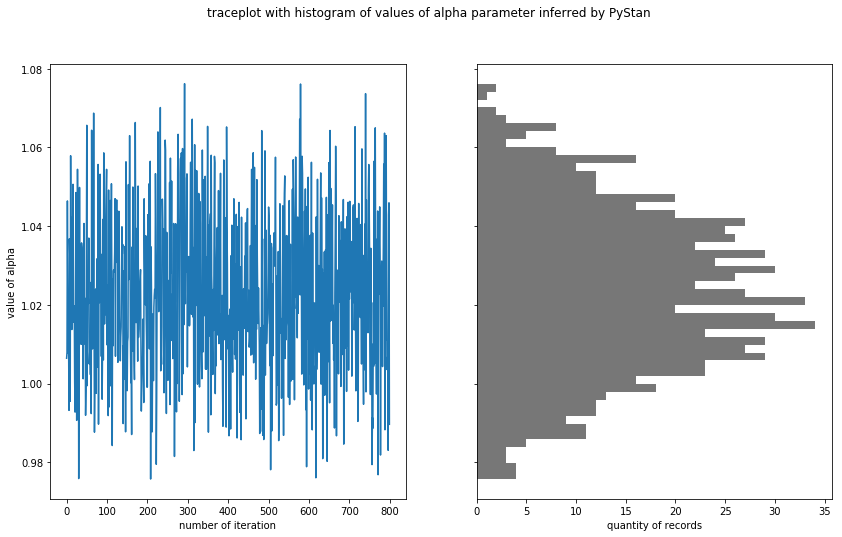

In [21]:
import matplotlib.pyplot as plt

# plot traceplots of parameters with the histogram displayed on the right side and rotated
# f = plt.figure()
# define window size, output and axes
fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])

# set x-axis name
ax[0].set_xlabel("number of iteration")
ax[0].plot(traceplot_alpha)
ax[0].set_ylabel("value of alpha")

# set y-axis name
ax[1].set_xlabel("quantity of records")
# ax[1].set_ylabel("number of records")

plt.suptitle('traceplot with histogram of values of alpha parameter inferred by PyStan')

# titles of subplots, here we don't use it 
# ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
# ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")


# create histogram within output
Nb, bins, patches = ax[1].hist(traceplot_alpha, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins

plt.show()
fig.savefig("PyStan_recovers_good_values_of_GPD.pdf", bbox_inches='tight')